In [1]:
from util.de_utils import *
from util.class_def.de_obj_classes import *
from util.plot_utils import *

from sklearn.preprocessing import RobustScaler

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load data
* RNAseq data
* Severe v Mild DEGs

In [2]:
path_prefix = "../../data/rnaseq_stanford_all/discovery/"
all_data = rnaseq_and_meta_data(path_prefix + "sample_meta_postQC.csv", 
                                path_prefix + "w_mild_severe/logCPM_postQC_RemovedBatch.csv", 
                                path_prefix + "TMM_postQC.csv",
                                is_logCPM_path_R = True,
                                counts_index_cols = [0],
                                mygene_db = mygene.MyGeneInfo()
                               )

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7160...done.
Finished.
15 input query terms found no hit:
	['ENSG00000116957', 'ENSG00000130723', 'ENSG00000133808', 'ENSG00000150076', 'ENSG00000155640', 'ENS
querying 1-15...done.
Finished.
8 input query terms found no hit:
	['AL356053.1', 'none', 'AC098614.2', 'CTB-133G6.1', 'none', 'RP11-367G6.3', 'none', 'none']


In [3]:
de_PE_sev_v_mild = de_data("out/de/w_mild_severe/DE_PEspecific_GA_PP_sev_v_mild_changes_timeToPE_w_covar_bmi_fsex_w_batch.csv", alpha = 0.05, de_type = 'PE preg changes', to_round = False)

print('%d DEGs detected' % de_PE_sev_v_mild.sig_genes.shape[0])

#What kind of genes are DE in PE
all_data.rnaseq.anno.loc[de_PE_sev_v_mild.sig_genes].gene_type.value_counts()

503 DEGs detected


protein_coding                        484
processed_pseudogene                   10
lncRNA                                  4
misc_RNA                                1
unprocessed_pseudogene                  1
snRNA                                   1
transcribed_unprocessed_pseudogene      1
Name: gene_type, dtype: int64

In [4]:
n_noncoding = all_data.rnaseq.anno.loc[de_PE_sev_v_mild.sig_genes].gene_type.value_counts()
n_noncoding = n_noncoding.loc[n_noncoding.index != 'protein_coding']
print('%d noncoding, (%.2f fraction)' % (n_noncoding.sum(), n_noncoding.sum() / de_PE_sev_v_mild.sig_genes.shape[0]))

18 noncoding, (0.04 fraction)


# Compare severe vs mild PE
* A proxy for multifactorial nature of PE

In [5]:
term_logFC_sig = logFC_data_by_group(de_PE_sev_v_mild.sig_genes, term_labels, CV_cutoff = 0.5, 
                                     logFC_cutoff = 1.2, lfc_col = 'pe_feature', 
                                     logFC_num = 'severe', logFC_denom = 'mild') 
term_logFC_sig.get_logFC_and_CI_by_group(all_data.rnaseq.logCPM.loc[de_PE_sev_v_mild.sig_genes, :], all_data.meta)

Now calculating logFC for <= 12 weeks gestation
Now calculating logFC for 13-20 weeks gestation
Now calculating logFC for >= 23 weeks gestation
Now calculating logFC for Post-partum
Now estimating logFC confidence interval for <= 12 weeks gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for 13-20 weeks gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for >= 23 weeks gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Post-partum
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


In [6]:
## Normalize data for plotting using zscore
#Get 1 sample per subj per time_group
samples_term = {term_labels[time_group] : 
                meta_term.loc[meta_term.case == 1].drop_duplicates(subset = 'subject', keep = 'first').index.to_list() 
                for time_group, meta_term in all_data.meta.groupby('term')}

fitted_scaler = {}
zscores_by_term = {}
pe_sig_terms = {}

min_zscore = None
max_zscore = None

CV_cutoff_by_term = {time_group : 0.5 for time_group in term_labels.values()}
CV_cutoff_by_term['<= 12 weeks gestation'] = 0.4

for time_group, samples in samples_term.items():
    
    #Zscore scale data
    logCPM_term = all_data.rnaseq.logCPM.loc[:, samples].T
    fitted_scaler[time_group] = StandardScaler().fit(logCPM_term)
    zscores_by_term[time_group] = preprocess_data(fitted_scaler[time_group], logCPM_term).T
    
    #Get genes that pass CV and logFC threshold 
    term_logFC_sig.mod_CV_mask(CV_cutoff_by_term[time_group])
    pe_sig_terms[time_group] = de_PE_sev_v_mild.sig_genes[np.logical_and(term_logFC_sig.CV_mask.loc[de_PE_sev_v_mild.sig_genes, time_group],
                                                              term_logFC_sig.logFC_mask.loc[de_PE_sev_v_mild.sig_genes, time_group]
                                                             )
                                              ]
    
    #Get min and max axs time groups for unified plotting
    curr_time_min_zscore = np.min(zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].to_numpy().flatten())
    curr_time_max_zscore = np.max(zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].to_numpy().flatten())
    
    min_zscore = curr_time_min_zscore if ((min_zscore is None) or (curr_time_min_zscore < min_zscore)) else min_zscore
    max_zscore = curr_time_max_zscore if ((max_zscore is None) or (curr_time_max_zscore > min_zscore)) else max_zscore

<= 12 weeks gestation: N DE genes used = 14, N samples = 13
13-20 weeks gestation: N DE genes used = 14, N samples = 16
>= 23 weeks gestation: N DE genes used = 13, N samples = 20
Post-partum: N DE genes used = 4, N samples = 17


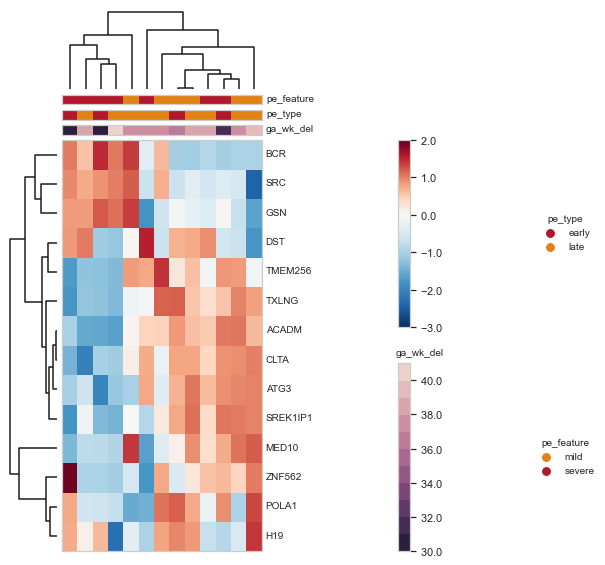

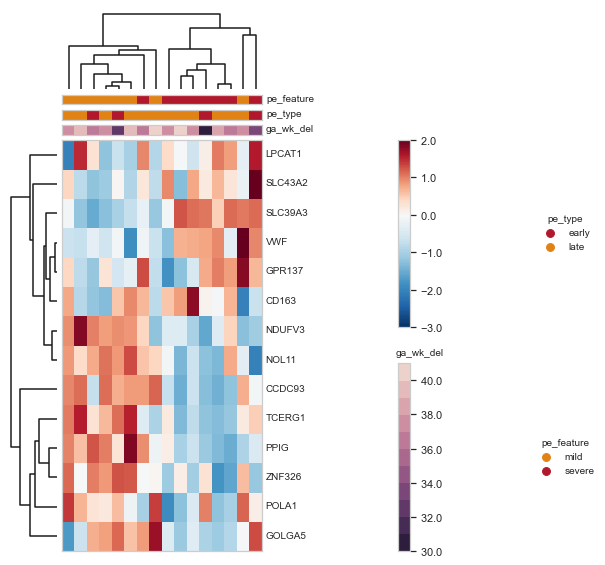

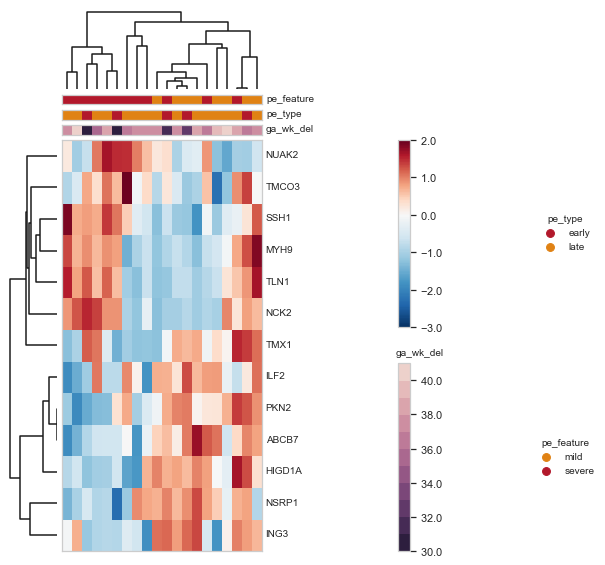

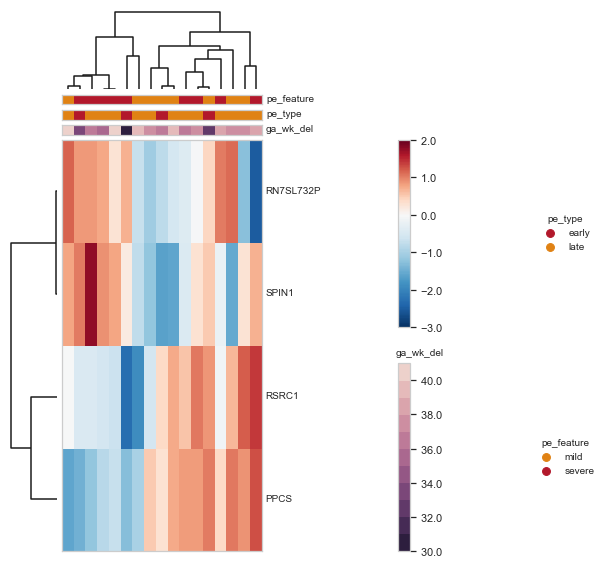

In [7]:
cmaps = {"pe_feature" : make_color_map("", pe_feat_palette2[1:]),
         "pe_type" : make_color_map("", list(reversed(pe_feat_palette2[1:]))),
         "ga_wk_del" : make_color_map("", sns.cubehelix_palette(len(all_data.meta.ga_wk_del.unique()), reverse = True).as_hex())}

zscore_cbar_params = {'min' : np.floor(min_zscore), 'mid' : 0, 'max' : np.ceil(max_zscore)} #So that color bar is consistent across figures 
row_order = {}
for time_group, samples in samples_term.items():  
    meta_term = all_data.meta.loc[samples]
    meta_term.loc[:, 'case'] = meta_term.case.astype(str)

    zscores_to_plot = zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].reset_index('gene_num', drop = True)
    print("%s: N DE genes used = %d, N samples = %s" % (time_group, zscores_to_plot.shape[0], meta_term.shape[0]))
    fig, plot, row_order[time_group] = nhm_plot_heatmap(zscores_to_plot, dfc = meta_term.loc[:, list(cmaps.keys())], cmaps = cmaps, center_args = zscore_cbar_params)


In [8]:
for time_group, pe_sig in pe_sig_terms.items():
    print(time_group)
    curr_time_group = pd.DataFrame(data = {time_group: [time_group]}, index = pe_sig)
    curr_time_group_anno = curr_time_group.join(all_data.rnaseq.anno)
    curr_time_group_anno.index.names = ['Gene', "ENSEMBL"]
    curr_time_group_anno.rename(columns = {'name' : 'Name', 'gene_type' : 'Type', 'summary' : 'Summary', 
                                    'GO_BP' : 'Biological process [GO]', 'GO_MF' : 'Molecular function [GO]'}, inplace = True)

    curr_time_group_anno.to_csv('out/de/sev_v_mild_viz/tp_tables/' + time_group.replace(' ', '_') + '_heatmap_genes_noColFormatting.csv')

<= 12 weeks gestation
13-20 weeks gestation
>= 23 weeks gestation
Post-partum


# Look at trends over time

Identified 4 clusters
N genes per cluster
1     83
2    133
3    134
4    153
Name: kmeans_cluster, dtype: int64
Percent features per cluster
1    0.17
2    0.26
3    0.27
4    0.30
Name: kmeans_cluster, dtype: float64


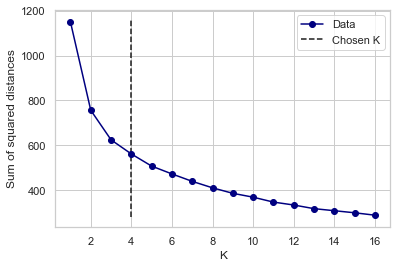

In [9]:
kmeans = kmeans_cluster(term_logFC_sig.logFC, n_max_clusters = 4**2, manually_choose_k = False) #4 time points with 2 possibiliites at each (DE or not)
save_figure_pdf(kmeans['elbow_plot'], 'out/de/sev_v_mild_viz/DE_kmeans_nClusters_QC.pdf')

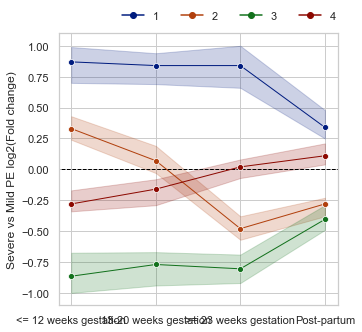

In [10]:
fig_kmeans, ax_kmeans = plot_lineplot(df = term_logFC_sig.logFC.join(kmeans['clusters']).melt(id_vars='kmeans_cluster', var_name = 'time', value_name = 'log2FC'), 
                                      x_name = 'time', y_name = 'log2FC', hue_name = 'kmeans_cluster', style_name = 'kmeans_cluster',
                                      markers = {cluster_i : 'o' for cluster_i in np.arange(1, kmeans['n_clusters'] + 1)}, 
                                      palette = 'dark', x_label = '', y_label = 'Severe vs Mild PE log2(Fold change)',
                                      include_hline = True, line_pos = 0, line_start = -1, line_end = 5)

h,l = ax_kmeans.get_legend_handles_labels()
plt.legend(h[1:], l[1:], ncol = kmeans['n_clusters'], frameon=0, bbox_to_anchor=(1.03, 1.12)) #[1, :] removes legend title
save_figure_pdf(fig_kmeans, 'out/de/sev_v_mild_viz/DE_kmeans_clusters.pdf')

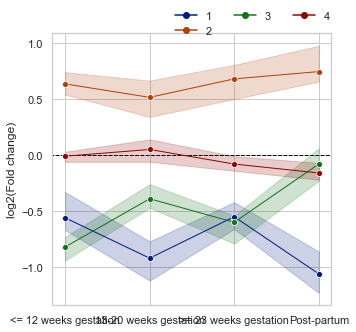

In [11]:
#Expect k-means to find non-flat lines. If data is permuted to disrupt corr across time between values for same gene, expect basically flat lines
permuted_kmeans = permute_and_kmeans(df = term_logFC_sig.logFC, 
                                     n_total_permutations = 1,
                                     n_max_clusters = 4**2, manually_choose_k = False, selected_k = 3)

#Plot permutation example
fig_kmeans_permuted, ax_kmeans_permuted = plot_lineplot(df = permuted_kmeans['permutation_ex'].join(permuted_kmeans['kmeans']['clusters']).melt(id_vars='kmeans_cluster', var_name = 'time', value_name = 'log2FC'), 
                                      x_name = 'time', y_name = 'log2FC', hue_name = 'kmeans_cluster', style_name = 'kmeans_cluster',
                                      markers = {cluster_i : 'o' for cluster_i in np.arange(1, permuted_kmeans['kmeans']['n_clusters'] + 1)}, 
                                      palette = 'dark', x_label = '', y_label = 'log2(Fold change)',
                                      include_hline = True, line_pos = 0, line_start = -1, line_end = 5)

h,l = ax_kmeans_permuted.get_legend_handles_labels()
plt.legend(h[1:], l[1:], ncol = 3, frameon=0, bbox_to_anchor=(1.03, 1.12)) #[1, :] removes legend title
save_figure_pdf(fig_kmeans_permuted, 'out/de/sev_v_mild_viz/DE_kmeans_clusters_PERMUTED.pdf')

In [12]:
tissue_sc_specific = pd.concat((read_tissue_spec_gini_csv("celltypes_for_mira_08052021/gini6_perCluster_kidney_12072020.csv", 'kidney'),
                                read_tissue_spec_gini_csv("celltypes_for_mira_08052021/gini6_perCluster_brain_NORMAL_01212021.csv", 'brain'),
                                read_tissue_spec_gini_csv("celltypes_for_mira_08052021/gini6_perCluster_heart_03152021.csv", 'heart'),
                                read_tissue_spec_gini_csv("celltypes_for_mira_08052021/gini6_perCluster_hepatocyte_12052020.csv", 'liver'),
                                    read_tissue_spec_gini_csv("celltypes_for_mira_08052021/placenta_hpa_2/hemant_tiechmann_hpa_gini_.6_cutoff.csv", 'placenta')
                               ), 
                               axis = 0
                              )

refs = {'hpa' : read_ref_ds('../../data/tissue_cell_type_ref/hpa_gini_coefs.csv', '../../data/tissue_cell_type_ref/hpa_mean_expr.csv', gini_cutoff = 0.6, is_tsp = False),
        'tsp' : read_ref_ds('../../data/tissue_cell_type_ref/giniCoefs_cfRNA__pe_10082021.csv', '../../data/tissue_cell_type_ref/meanExpr_deg_cfRNA__pe_10082021.csv', gini_cutoff = 0.8, is_tsp = True),
       }

#Augment TSP with missing tissues (placenta, brain) and cell-types (eg cardiomyocyte in heart, proximal tubule in kidney)
refs['tsp_aug'] = tissue_sc_specific.join(refs['tsp'], rsuffix = '_tsp', how = 'outer')
is_na_aug = refs['tsp_aug'].loc[refs['tsp_aug'].isna().max_exp_in].index
refs['tsp_aug'].loc[is_na_aug, 'Gini'] = refs['tsp_aug'].loc[is_na_aug, 'Gini_tsp']
refs['tsp_aug'].loc[is_na_aug, 'max_exp_in'] = refs['tsp_aug'].loc[is_na_aug, 'max_exp_in_tsp']

refs.pop('tsp')

,Gini,max_exp_in
gene_num,,
ENSG00000223972,0.947525,platelet
ENSG00000278267,0.962301,pancreatic alpha cell
ENSG00000243485,0.964499,goblet cell
ENSG00000237613,0.988156,leucocyte
ENSG00000268020,0.991631,hematopoietic stem cell
...,...,...
ENSG00000215506,0.963951,mucus secreting cell
ENSG00000227629,0.978321,adventitial cell
ENSG00000237917,0.903955,slow muscle cell


Index([], dtype='object')
Index([], dtype='object')


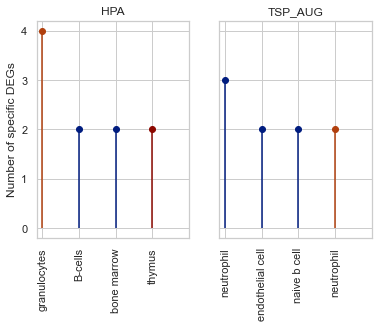

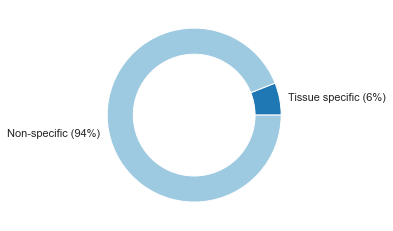

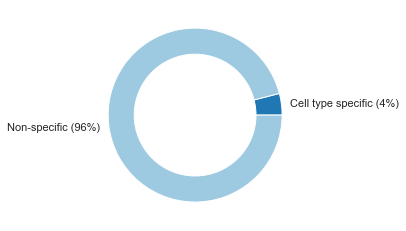

In [13]:
all_refs_DEG_enrichment = None
alpha = {'hpa' : 0.05, 'tsp_aug' : 0.05}
stemplot_fig, stemplot_ax = plt.subplots(1, len(alpha.keys()), sharey = True)

i = 0
for ref_name, ref_df in refs.items():
    deg_kmeans_isec, pct_isec, pct_non_specific = get_de_ref_kmeans_intersection_and_fracs(de_PE_sev_v_mild.de.loc[de_PE_sev_v_mild.sig_genes, 'adj_pval'].to_frame(), ref_df, kmeans['clusters']).values()
    ref_specific_to = 'Tissue' if ref_name == 'hpa' else 'Cell type'
    
    donut_fig = plot_donut(fractions = [pct_isec, pct_non_specific], 
                           labels = ['%s specific (%d%%)' % (ref_specific_to, pct_isec), 
                                     'Non-specific (%d%%)' % (pct_non_specific)],
                          palette = discovery_validation_palette)
    
    ref_DEG_enrichment = test_DEGs_for_ref_enrichment(deg_kmeans_isec, ref_df, ref_specific_to, alpha = alpha[ref_name])
    all_refs_DEG_enrichment = ref_DEG_enrichment if all_refs_DEG_enrichment is None else pd.concat((all_refs_DEG_enrichment, ref_DEG_enrichment))
    
    stemplot_fig, _  = plot_stemplot_w_grouping(df = ref_DEG_enrichment.loc[ref_DEG_enrichment.is_sig].sort_values(by = 'n_DEG_specific_to_this', ascending=False).reset_index().reset_index(), 
                                                x_name = 'index', y_name = 'n_DEG_specific_to_this', 
                                                color_list = sns.color_palette(palette='dark', n_colors=kmeans['n_clusters']).as_hex(),
                                                group_name = 'kmeans_cluster', 
                                                xtick_name = 'specific_to', xlabel = '', 
                                                ylabel = 'Number of specific DEGs' if i == 0 else '',
                                                title = ref_name.upper(),
                                                fig = stemplot_fig, ax = stemplot_ax[i])

    i += 1
    save_figure_pdf(donut_fig, 'out/de/sev_v_mild_viz/' + ref_name + 'donut.pdf')
    
save_figure_pdf(stemplot_fig, 'out/de/sev_v_mild_viz/' + 'stemplots_all_to_mark_w_sig.pdf')

In [14]:
all_refs_DEG_enrichment

n_DEG_specific_to_this  \
kmeans_cluster specific_to                               
1              B-cells                               2   
               bone marrow                           2   
2              cerebral cortex                       2   
               granulocytes                          4   
4              thymus                                2   
1              endothelial cell                      2   
               naive b cell                          2   
               neutrophil                            3   
2              neutrophil                            2   

                                n_genes_specific_to_this  \
kmeans_cluster specific_to                                 
1              B-cells                                23   
               bone marrow                            81   
2              cerebral cortex                       463   
               granulocytes                          121   
4              thymus                                193   
1              endothelial cell                     1262   
               naive b cell                           48   
               neutrophil                            930   
2              neutrophil                            930   

                                n_DEGs_specific_to_any_name_for_query  \
kmeans_cluster specific_to                                              
1              B-cells                                             10   
               bone marrow                                         10   
2              cerebral cortex                                     13   
               granulocytes                                        13   
4              thymus                                               4   
1              endothelial cell                                     9   
               naive b cell                                         9   
               neutrophil                                           9   
2              neutrophil                                           8   

                                       p_val       DEGs_included        ref  \
kmeans_cluster specific_to                                                    
1              B-cells           0.000751131          FCMR,TCL1A     Tissue   
               bone marrow        0.00908768          PADI4,DOK3     Tissue   
2              cerebral cortex      0.304108           MLC1,RTN1     Tissue   
               granulocytes      0.000141577  SELL,HK3,MXD1,ALPL     Tissue   
4              thymus             0.00714141    CARMIL2,ARHGAP15     Tissue   
1              endothelial cell    0.0354939           PDE2A,VWF  Cell type   
               naive b cell      5.86415e-05     TCL1A,TNFRSF13C  Cell type   
               neutrophil         0.00117714     PADI4,MEFV,DOK3  Cell type   
2              neutrophil          0.0158911            FCN1,HK3  Cell type   

                                 adj_pval  is_sig  
kmeans_cluster specific_to                         
1              B-cells           0.001878    True  
               bone marrow       0.011360    True  
2              cerebral cortex   0.304108   False  
               granulocytes      0.000708    True  
4              thymus            0.011360    True  
1              endothelial cell  0.035494    True  
               naive b cell      0.000235    True  
               neutrophil        0.002354    True  
2              neutrophil        0.021188    True

In [15]:
all_refs_DEG_enrichment.loc[all_refs_DEG_enrichment.is_sig]

n_DEG_specific_to_this  \
kmeans_cluster specific_to                               
1              B-cells                               2   
               bone marrow                           2   
2              granulocytes                          4   
4              thymus                                2   
1              endothelial cell                      2   
               naive b cell                          2   
               neutrophil                            3   
2              neutrophil                            2   

                                n_genes_specific_to_this  \
kmeans_cluster specific_to                                 
1              B-cells                                23   
               bone marrow                            81   
2              granulocytes                          121   
4              thymus                                193   
1              endothelial cell                     1262   
               naive b cell                           48   
               neutrophil                            930   
2              neutrophil                            930   

                                n_DEGs_specific_to_any_name_for_query  \
kmeans_cluster specific_to                                              
1              B-cells                                             10   
               bone marrow                                         10   
2              granulocytes                                        13   
4              thymus                                               4   
1              endothelial cell                                     9   
               naive b cell                                         9   
               neutrophil                                           9   
2              neutrophil                                           8   

                                       p_val       DEGs_included        ref  \
kmeans_cluster specific_to                                                    
1              B-cells           0.000751131          FCMR,TCL1A     Tissue   
               bone marrow        0.00908768          PADI4,DOK3     Tissue   
2              granulocytes      0.000141577  SELL,HK3,MXD1,ALPL     Tissue   
4              thymus             0.00714141    CARMIL2,ARHGAP15     Tissue   
1              endothelial cell    0.0354939           PDE2A,VWF  Cell type   
               naive b cell      5.86415e-05     TCL1A,TNFRSF13C  Cell type   
               neutrophil         0.00117714     PADI4,MEFV,DOK3  Cell type   
2              neutrophil          0.0158911            FCN1,HK3  Cell type   

                                 adj_pval  is_sig  
kmeans_cluster specific_to                         
1              B-cells           0.001878    True  
               bone marrow       0.011360    True  
2              granulocytes      0.000708    True  
4              thymus            0.011360    True  
1              endothelial cell  0.035494    True  
               naive b cell      0.000235    True  
               neutrophil        0.002354    True  
2              neutrophil        0.021188    True

In [16]:
all_refs_DEG_enrichment.query('is_sig').reset_index().replace({'ref' : {'Tissue' : 'HPA', 
                                                        'Cell type' : 'TSP+'}, 
                                               'kmeans_cluster' : {1 : '1, Increased across gestation for severe PE',
                                                                   2 : '2, Increased and then decreased in early and late gestation respectively for severe PE',
                                                                  3 : '3, Decreased only in early gestation for severe PE',
                                                                  4 : '4, Decreased across gestation for severe PE'}}).sort_values(['kmeans_cluster','adj_pval']).set_index(['kmeans_cluster', 'specific_to']).loc[:, ['ref', 'adj_pval', 'DEGs_included']].to_csv('out/de/sev_v_mild_viz/DEG_organ_ct_enrichment.csv')

In [17]:
term_logFC_sig.logFC.join(term_logFC_sig.CV, lsuffix = " logFC", rsuffix = " CV").sort_values(['<= 12 weeks gestation CV', '13-20 weeks gestation CV', '>= 23 weeks gestation CV', 'Post-partum CV']).to_csv('out/de/sev_v_mild_viz/DEG_logFC_CV.csv')

In [18]:
go_queries = {str(cluster_i) : kmeans['clusters'].loc[kmeans['clusters'] == cluster_i].index.get_level_values('gene_num').to_list() for cluster_i in np.arange(1, kmeans['n_clusters'] + 1)}
sources_to_include = ['GO:BP', 'REAC', 'KEGG', 'GO:CC']
alpha = 0.05
go_table, go_table_pruned = get_and_prune_go_table(go_queries, 
                                                   choose_parent = False,
                                                   organism = 'hsapiens',
                                                   sources = sources_to_include, 
                                                   domain_scope = 'custom', 
                                                   no_evidences = False, 
                                                   no_iea = True,
                                                   user_threshold = alpha,
                                                   all_results = False,
                                                   background = all_data.rnaseq.logCPM.index.get_level_values('gene_num').to_list()
                                                  )

GO table has 76 terms
GO table has 45 terms after pruning


In [19]:
go_table

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
12,GO:BP,GO:0002181,cytoplasmic translation,1.255659e-10,True,"""The chemical reactions and pathways resulting...",117,153,22,7144,0.143791,0.188034,4,[GO:0006412],"[ENSG00000106682, ENSG00000171858, ENSG0000016...","[[IBA], [IDA, IC], [IBA, IC], [IC], [IBA], [IC..."
14,GO:BP,GO:0006613,cotranslational protein targeting to membrane,1.651458e-10,True,"""The targeting of proteins to a membrane that ...",93,153,20,7144,0.130719,0.215054,4,[GO:0006612],"[ENSG00000171858, ENSG00000163682, ENSG0000022...","[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
15,GO:BP,GO:0006614,SRP-dependent cotranslational protein targetin...,6.276288e-10,True,"""The targeting of proteins to a membrane that ...",87,153,19,7144,0.124183,0.218391,4,"[GO:0006613, GO:0045047]","[ENSG00000171858, ENSG00000163682, ENSG0000022...","[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
21,GO:BP,GO:0000184,"nuclear-transcribed mRNA catabolic process, no...",7.186082e-09,True,"""The nonsense-mediated decay pathway for nucle...",112,153,20,7144,0.130719,0.178571,4,[GO:0000956],"[ENSG00000171858, ENSG00000163682, ENSG0000022...","[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
23,GO:BP,GO:0000956,nuclear-transcribed mRNA catabolic process,9.758089e-09,True,"""The chemical reactions and pathways resulting...",175,153,24,7144,0.156863,0.137143,4,[GO:0006402],"[ENSG00000184708, ENSG00000171858, ENSG0000016...","[[IDA], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,REAC,REAC:R-HSA-72662,Activation of the mRNA upon binding of the cap...,8.222987e-06,True,Activation of the mRNA upon binding of the cap...,58,153,13,7144,0.084967,0.224138,4,[REAC:R-HSA-72737],"[ENSG00000106682, ENSG00000171858, ENSG0000017...","[[REAC], [REAC], [REAC], [REAC], [REAC], [REAC..."
47,REAC,REAC:R-HSA-72695,"Formation of the ternary complex, and subseque...",1.819444e-05,True,"Formation of the ternary complex, and subseque...",50,153,12,7144,0.078431,0.240000,4,[REAC:R-HSA-72737],"[ENSG00000171858, ENSG00000171863, ENSG0000013...","[[REAC], [REAC], [REAC], [REAC], [REAC], [REAC..."
54,REAC,REAC:R-HSA-8953854,Metabolism of RNA,1.569591e-04,True,Metabolism of RNA,498,153,33,7144,0.215686,0.066265,4,[REAC:0000000],"[ENSG00000163510, ENSG00000136450, ENSG0000017...","[[REAC], [REAC], [REAC], [REAC], [REAC], [REAC..."
70,REAC,REAC:R-HSA-422475,Axon guidance,1.285773e-02,True,Axon guidance,320,153,23,7144,0.150327,0.071875,4,[REAC:R-HSA-9675108],"[ENSG00000241685, ENSG00000171858, ENSG0000009...","[[REAC], [REAC], [REAC], [REAC], [REAC], [REAC..."


In [20]:
dbPEC = pd.read_csv('../../data/dbPEC_resource/pe_all_genes.csv', index_col = 0)

dbPEC_obs_isec = dbPEC.index.intersection(de_PE_sev_v_mild.sig_genes.get_level_values('gene_name'))
dbPEC_obs_isec_size = dbPEC_obs_isec.shape[0]

dbPEC_null_dist = [dbPEC.index.intersection(pd.Series(all_data.rnaseq.anno.index.get_level_values('gene_name')).sample(n = de_PE_sev_v_mild.sig_genes.shape[0], replace = False, random_state = i)).shape[0] for i in np.arange(1000)]

print('Intersection size = %d with following genes: %s' % (dbPEC_obs_isec_size, ', '.join(dbPEC_obs_isec.to_list())))
print()
print('Is there sig overlap between dbPEC and DEGs by permutation test? P-val = %f' % permutation_test(dbPEC_obs_isec_size, np.array(dbPEC_null_dist)))
print('Is there sig overlap between dbPEC and DEGs by hypergeometric test? P-val = %f' % scipy.stats.hypergeom(M = all_data.rnaseq.logCPM.shape[0], 
                                                                                                               n = dbPEC.index.intersection(all_data.rnaseq.logCPM.index.get_level_values('gene_name')).shape[0],
                                                                                                               N = de_PE_sev_v_mild.sig_genes.shape[0]).sf((dbPEC_obs_isec_size - 1)))

Intersection size = 12 with following genes: HSP90AB1, VWF, CDKN1A, ATP2A3, SELL, GSTP1, CD163, H19, HIF1AN, ZCCHC7, JUNB, ACADM

Is there sig overlap between dbPEC and DEGs by permutation test? P-val = 0.894110
Is there sig overlap between dbPEC and DEGs by hypergeometric test? P-val = 0.896376


# Measure placental signal over gest

In [21]:
all_data_no_gene_QC = rnaseq_and_meta_data(path_prefix + "sample_meta_postQC.csv", 
                                path_prefix + "htseq_postSampleQC_noGeneQC.csv", 
                                path_prefix + "TMM_postQC.csv",
                                is_logCPM_path_R = False,
                               )

val_path_prefix = "../../data/rnaseq_stanford_all/val/" 
all_data_no_gene_QC.join(rnaseq_and_meta_data(val_path_prefix + "sample_meta_postQC.csv", 
                                              val_path_prefix + "htseq_postSampleQC_noGeneQC.csv", 
                                              val_path_prefix + "TMM_postQC.csv")
                        )

In [22]:
panels = {'Nervous' : ['astrocytes', 'excitatory neurons', 'inhibitory neurons', 'oligodendrocytes', 'oligodendrocyte progenitor cells'],
          'Immune' : ['bone marrow', 'B-cells', 'T-cells', 'NK-cells', 'granulocytes'],
          'Placenta' : ['placenta', 'extravillous trophoblasts', 'syncytiotrophoblasts'],
          'Heart' : ['heart muscle', 'atrial cardiomyocyte', 'ventricular cardiomyocyte'],
          'Liver' : ['liver', 'hepatocytes', 'liver sinusoidal endothelial cells'],
          'Kidney' : ['kidney', 'proximal tubule'],
          'Endothelial' : ['platelet', 'endothelial cell'],
          'Muscle' : ['skeletal muscle', 'smooth muscle']
         }

In [23]:
refs['hpa_strict'] = refs['hpa'].loc[refs['hpa']['RNA tissue specificity'].isin(['Tissue enriched', 'Tissue enhanced'])]

In [24]:
min_for_sig = 5

meta_cols = ['pe_feature', 'term', 'subject', 'pe_type', 'case', 'time_to_pe_onset']
sig_scores = all_data.meta.loc[:, meta_cols]

gene_sig = {'Cell type or tissue' : [], 'Total number of genes' : [], 'Gene' : [], 'ENSEMBL' : []}

ct_tissue_score_len = {}
for ct_tissues in panels.values():
    for ct_tissue in  ct_tissues:
        if ct_tissue in refs['hpa_strict'].max_exp_in.unique():
            genes_idx = refs['hpa_strict'].loc[refs['hpa_strict']['max_exp_in'] == ct_tissue]
        elif ct_tissue.lower() in refs['tsp_aug'].max_exp_in.unique():
            genes_idx = refs['tsp_aug'].loc[refs['tsp_aug']['max_exp_in'] == ct_tissue]
        
        genes_idx = genes_idx.index
        if genes_idx.shape[0] < min_for_sig:
            continue
             
        ct_tissue_score_len[ct_tissue] = genes_idx.shape[0]
        full_gene_idx = all_data_no_gene_QC.rnaseq.logCPM.loc[all_data_no_gene_QC.rnaseq.logCPM.index.get_level_values('gene_num').isin(genes_idx)].index
        
        gene_sig['Cell type or tissue'].append(ct_tissue)
        gene_sig['Total number of genes'].append(genes_idx.shape[0])
        gene_sig['Gene'].append(', '.join(full_gene_idx.get_level_values('gene_name').to_list()))
        gene_sig['ENSEMBL'].append(', '.join(full_gene_idx.get_level_values('gene_num').to_list()))
        
        specific_sig_score = pd.Series(all_data_no_gene_QC.rnaseq.logCPM.loc[full_gene_idx].sum(axis = 0), name = ct_tissue)
        sig_scores = sig_scores.join(specific_sig_score)

In [25]:
sig_scores_long = sig_scores.reset_index().melt(id_vars = ['index'] + meta_cols, var_name = 'ct', value_name = 'sig_score')
sig_scores_long['pe_feature'] = pd.Categorical(sig_scores_long['pe_feature'], ordered = True, categories = ['control', 'mild', 'severe'])

In [26]:
sig_scores_long['sig_score_norm'] = np.nan
sig_scores_long['sig_score_norm_scaled'] = np.nan

for grouping, df in sig_scores_long.groupby(['ct', 'subject']):
    ct, subj = grouping
    if (df.term == 4).sum() == 0:
        continue
    
    sig_scores_long.loc[df.index, 'sig_score_norm'] = df.loc[:, 'sig_score'] - df.loc[df.term == 4, 'sig_score'].to_list()[0]
    sig_scores_long.loc[df.index, 'sig_score_norm_scaled'] = RobustScaler(with_centering = False).fit_transform(sig_scores_long.loc[df.index,['sig_score_norm']])[:, 0]

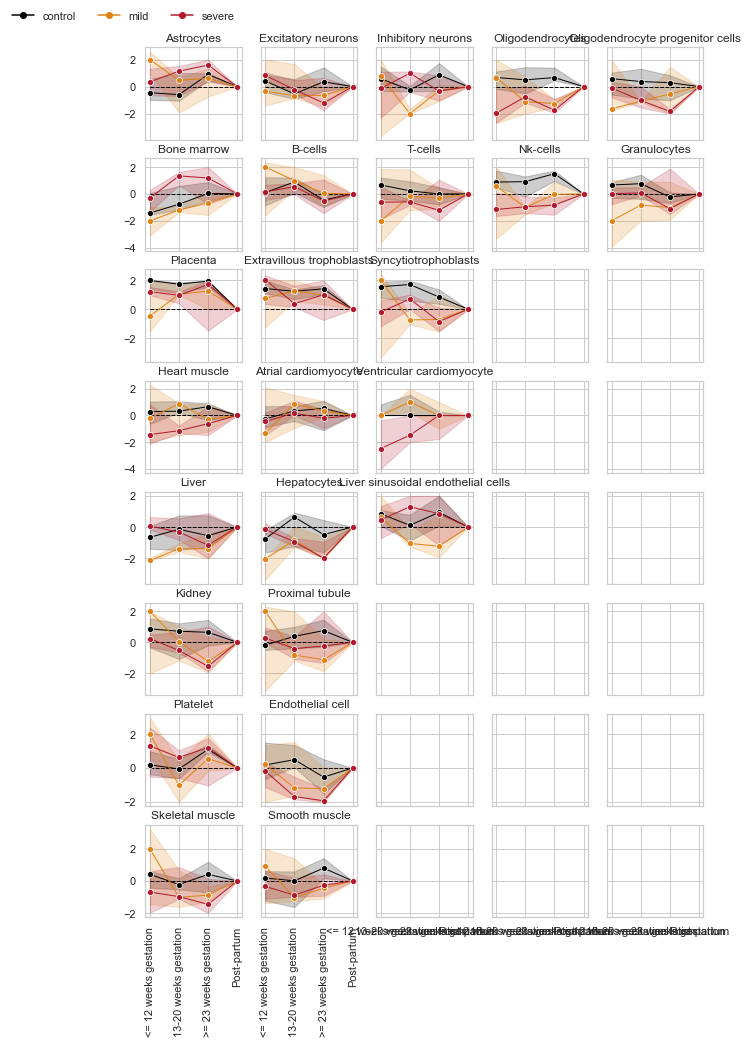

In [27]:
hue_marker_names = ['pe_feature']

n_panels = len(panels.keys())
n_ct_tissue = max([len(val) for val in panels.values()])

for hue_marker_name in hue_marker_names:
    fig, ax = plt.subplots(n_panels, n_ct_tissue, figsize = (n_ct_tissue * 2, n_panels * 2), sharex = True, sharey = 'row')
    panel_0 = True
    
    i = 0
    for panel, ct_tissues in panels.items():
        j = 0
        for ct_tissue in ct_tissues:
            df = sig_scores_long.loc[sig_scores_long['ct'] == ct_tissue]

            plot_lineplot(df.sort_values(['term', hue_marker_name]),  
                          'term', 'sig_score_norm_scaled', hue_marker_name, hue_marker_name, 
                          {feat : 'o' for feat in df[hue_marker_name].unique()}, pe_feat_palette2, 
                          '', '', include_hline = True, line_pos = 0, line_start = 1, line_end = 4,
                          fig = fig, ax = ax[i, j], ci = 75)
            
            if j > 0 or not panel_0:
                ax[i,j].legend().remove()
            else:
                h,l = ax[i,j].get_legend_handles_labels()
                ax[i,j].legend(h[1:], l[1:], ncol = 5, frameon=0, bbox_to_anchor=(1.03, 1.5))
                panel_0 = False

            ax[i,j].set_xticks(list(term_labels.keys()))
            ax[i,j].set_xticklabels(list(term_labels.values()), rotation = 90)  
            ax[i,j].set_title(ct_tissue.capitalize())
            j += 1

        i += 1
        j = 0

    save_figure_pdf(fig, 'out/ct_tissue_viz/all_' + hue_marker_name + '.pdf')